# Feature Engineering  & Synthetic Transformers
Project Hadron provides a library of transformers, which may clean, reduce, expand or generate feature representations. Machine learning models have very specific ingestion needs such as numeric only non-null data, normalised looking distributions and optimised features of interest, without which the model will produce poor results.

The main agenda for a model to be accurate and precise in predictions, is that the algorithm should be able to easily interpret the data's features. The majority of the real-world datasets for machine learning are highly susceptible to be sparce, inconsistent, and noisy due to their heterogeneous origin, while models have high expectations of the format, veracity, size and quality of the data they ingest.

Data transformation is a required first step before any machine learning model can be applied, because the algorithms learn from the data and the learning outcome for problem solving heavily depends on the proper data needed to solve a particular problem. Data transformation is an integral step in Machine Learning as the quality of data and the useful information that can be derived from it directly affects the ability of a model to learn.

In [1]:
# saves you having to use print as all exposed variables are printed in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from ds_discovery import Wrangle, SyntheticBuilder, Transition, Commons

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Components Used

In [4]:
# in-memory instances
builder = SyntheticBuilder.from_memory()
tr = Transition.from_memory()
wr = Wrangle.from_memory()

## Dimensionality Reduction
Dimensionality reduction is a machine learning or statistical technique of reducing the features of a given dataset in a problem by obtaining a set of principal features of relevance whose representation retains some meaningful properties of the original dataset.

In [5]:
sample_size = 1000
df = pd.DataFrame(index=range(sample_size))
df['nulls'] = [np.nan] * sample_size
df['ones'] = builder.tools.get_ones_zeros(sample_size)
df['more_ones'] = df['ones']
df['zeroes'] = builder.tools.get_ones_zeros(sample_size, ones=False)
df['cats'] = builder.tools.get_category(selection=['A','B'], size=sample_size)
df['nums'] = builder.tools.get_number(100, size=sample_size)
df['more_nums'] = builder.tools.correlate_values(df, header='nums', jitter=0.3)
df.columns.to_list()

['nulls', 'ones', 'more_ones', 'zeroes', 'cats', 'nums', 'more_nums']

### Feature selection
Feature selection is the process of selecting a subset of relevant features or variables, reducing the dimensionality of the dataset. There are three strategies for future selection, filter methods, wrapper methods, and embedded methods. Preprocessing predominantly tends to use filter methods which rely on the characteristics of the data. These tend to not use machine learning algorithms and are thus model agnostic giving them more scope as a pre-processing tool. Finally they are less computationally expensive and though they give a lower prediction performance they are suited for quick removal of irrelevant features.

Wrapper methods are not commonally used as they are computationaly very expensive. Embedded methods are found closer to the model and tend to perform feature selection as part of the model's construction process.

In [6]:
df = tr.tools.auto_drop_duplicates(df)

In [7]:
# 'ones' column has been dropped
df.columns.to_list()

['nulls', 'more_ones', 'zeroes', 'cats', 'nums', 'more_nums']

In [8]:
df = tr.tools.auto_drop_columns(df)

In [9]:
# 'zeros' and 'nulls' columns have been dropped
df.columns.to_list()

['cats', 'nums', 'more_nums']

In [10]:
df = tr.tools.auto_drop_correlated(df, threshold=0.8)

In [11]:
# 'nums' column has been dropped
df.columns.to_list()

['cats', 'more_nums']

### Feature projection
Feature projection transforms the data from the high-dimensional space to a space of fewer dimensions. To achieve this transformation we use principal component analysis (PCA). PCA, is a dimensionality-reduction method that transforms a large set of features into a more manageable smaller set that still contain most of the information in the large set.

We start with a dimensionality of 1000x22.

In [12]:
df = builder.tools.model_synthetic_classification(sample_size, n_features=20)
df['cats'] = builder.tools.get_category(selection=['A','B'], size=sample_size)
df.shape

(1000, 22)

In [13]:
df = tr.tools.auto_projection(df, headers=['target'], drop=True, n_components=4)

After running our projection we have reduced the dimensionality to 1000x6. We specifically didn't include ``target`` and ``cats`` was excluded as it isn't numeric. 

In [14]:
df.columns.to_list()

['target', 'cats', 'pca_A', 'pca_B', 'pca_C', 'pca_D']

## Missing data imputation
Imputation is the act of replacing missing data with statistical estimates of the missing values. The goal of any imputation technique is to produce a complete dataset that can be used to train machine learning models.  There are three types of missing data:
* Missing Completely at Random (MCAR); where the missing data has nothing to do with another feature(s)
* Missing at Random (MAR); where missing data can be interpreted from another feature(s)
* Missing not at Random (MNAR); where missing data is not random and can be interpreted from another feature(s)

When choosing a strategy to replace missing data, understanding the type of data that is missing is critical to the approach one takes in replacing it.


In [15]:
sample_size = 100
df = pd.DataFrame(index=range(sample_size))
df['num_nulls'] = builder.tools.get_dist_normal(mean=0, std=1, quantity=.9, size=sample_size, seed=11)
builder.canonical_report(df, stylise=False)

,Attributes (1),dType,%_Null,%_Dom,Count,Unique,Observations
0,num_nulls,float64,0.1,0.1,100,90,max=2.024 | min=-1.92 | mean=0.01 | dominant=-0.814


Mean and median imputation is a commonly used technique, consisting of replacing all occurrences of missing values by the mean, if the variable has a Gaussian distribution, or median, if the variable has a skewed distribution. Replacing missing data by the mode is not common practice. As the mean and median methods apply to numeric values only, they are only suitable for continuous and discrete numerical variables. 

In [16]:
df['mean'] = wr.tools.correlate_missing(df, header='num_nulls', method='mean', seed=11)

<Figure size 600x400 with 0 Axes>

<AxesSubplot: xlabel='num_nulls', ylabel='Density'>

<AxesSubplot: xlabel='num_nulls', ylabel='Density'>

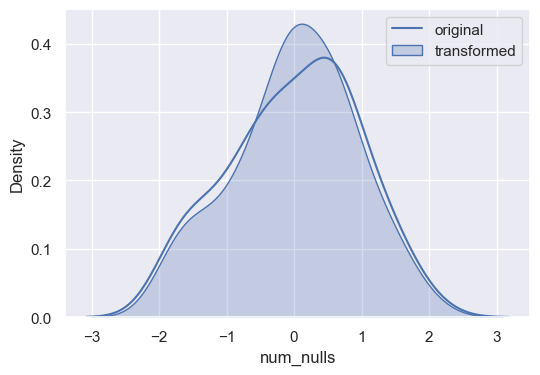

In [17]:
plt.figure(figsize=(6,4))
sns.set()
sns.kdeplot(data=df['num_nulls'])
sns.kdeplot(data=df['mean'], fill=True)
plt.legend(labels=["original", "transformed"])
plt.show()

A popular approach to missing data imputation is to use a model to predict the missing values. Although any one among a range of different models can be used to predict the missing values, the k-nearest neighbor (KNN) algorithm has proven to be generally effective. We use it here where a new sample is imputed by finding the samples in the dataset closest to that sample and average nearby points to fill in the value.

In [18]:
df['knn'] = wr.tools.correlate_missing(df, header='num_nulls', method='neighbour', weights='weighted', seed=11)

<Figure size 600x400 with 0 Axes>

<AxesSubplot: xlabel='num_nulls', ylabel='Density'>

<AxesSubplot: xlabel='num_nulls', ylabel='Density'>

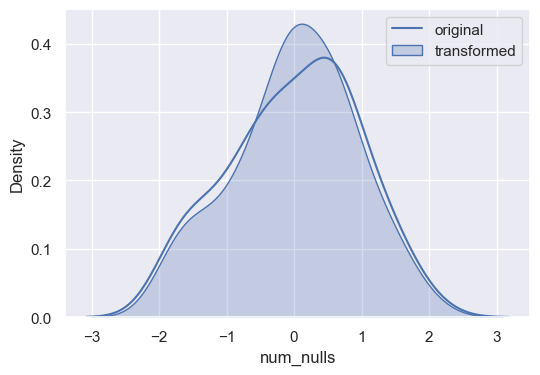

In [19]:
plt.figure(figsize=(6,4))
sns.set()
sns.kdeplot(data=df['num_nulls'])
sns.kdeplot(data=df['knn'], fill=True)
plt.legend(labels=["original", "transformed"])
plt.show()

Random sampling imputation is in principle similar to mean, median, and mode imputation in that it considers that missing values should look like those already existing in the distribution. Random sampling consists of taking random observations from the pool of available data and using them to replace the missing data. In random sample imputation, we take as many random observations as missing values exist in the variable.

In both numerical and categorical variables, the distribution of the variable is preserved by sampling observations at random to replace missing data.



In [20]:
df['random'] = wr.tools.correlate_missing(df, header='num_nulls', method='random', seed=11)

<Figure size 600x400 with 0 Axes>

<AxesSubplot: xlabel='num_nulls', ylabel='Density'>

<AxesSubplot: xlabel='num_nulls', ylabel='Density'>

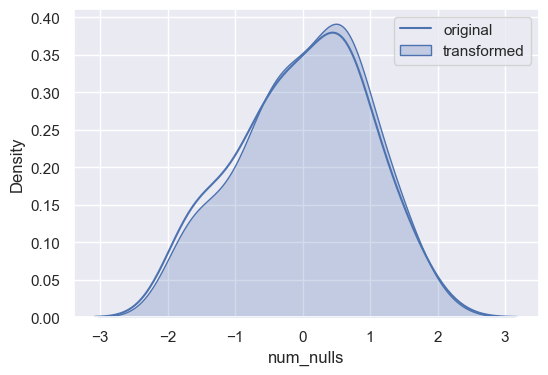

In [21]:
plt.figure(figsize=(6,4))
sns.set()
sns.kdeplot(data=df['num_nulls'])
sns.kdeplot(data=df['random'], fill=True)
plt.legend(labels=["original", "transformed"])
plt.show()

One of the metod options is Indicator. Indicator is not an imputation method but an imputation techniques. Imputations such as mean, median and random will affect the variable distribution quite dramatically and is a good idea to flag them with a missing indicator before their imputation to tag values are where real and those that have been modified.

In [22]:
df['indicator'] = wr.tools.correlate_missing(df, header='num_nulls', method='indicator')

In [23]:
df['indicator'].value_counts()

0    90
1    10
Name: indicator, dtype: int64

## Categorical encoding
Categorical encoding is a process where we transform categorical data into representative numerical data. It is a critical step in data pre-processing where most models expect numerical input.

In [24]:
sample_size = 100
df = pd.DataFrame(index=range(sample_size))
df['gender'] = builder.tools.get_category(selection=['M','F','U'], relative_freq=[6,4,1], size=sample_size, seed=11)
df['code'] = builder.tools.get_category(selection=['90674', '90682', '90686', '90688', '90694', '90756'], relative_freq=[13, 9, 7, 4, 2, 1], size=sample_size, seed=11)

We start with count encoding where by we replace the categories by the count of the observations for that category. The assumption of this technique is that the number observations shown by each variable is somewhat informative of the predictive power of the category. The obvious danger is if 2 different categories appear the same amount of times in the dataset.

In [25]:
df_encoded = wr.tools.model_encode_count(df, headers=['gender', 'code'],)

In [26]:
df_encoded.head()

,gender,code
0,58,28
1,58,28
2,36,9
3,6,10
4,36,10


<Figure size 600x300 with 0 Axes>

<AxesSubplot: >

<AxesSubplot: xlabel='gender', ylabel='Count'>

Text(0.5, 1.0, 'Original')

<AxesSubplot: >

<AxesSubplot: xlabel='gender', ylabel='Count'>

Text(0.5, 1.0, 'Count Encoded')

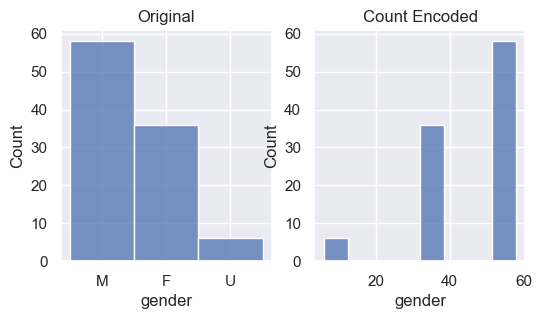

In [27]:
plt.figure(figsize=(6,3))
plt.subplot(121)
sns.histplot(data=df['gender'])
plt.title('Original')
plt.subplot(122)
sns.histplot(data=df_encoded['gender'])
plt.title('Count Encoded')

Integer encoding replaces the categories by digits from 1 to n, where n is the number of distinct categories of the variable. Integer encoding can be either nominal or orinal.

Nominal data is categorical variables without any particular order between categories. This means that the categories cannot be sorted and there is no natural order between them. 

Ordinal data represents categories with a natural, ordered relationship between each category. This means that the categories can be sorted in either ascending or descending order. In order to encode integers as ordinal, a ranking must be provided.

In [28]:
df_encoded = wr.tools.model_encode_interger(df, headers=['gender', 'code'])

AttributeError: 'WrangleIntentModel' object has no attribute 'model_encode_interger'

In [ ]:
plt.figure(figsize=(9,3))
plt.subplot(121)
sns.histplot(data=df['code'])
plt.title('Original')
plt.subplot(122)
sns.histplot(data=df_encoded['code'])
plt.title('Ordinal Encoded')

One hot encoding, creates a new column for each categorical variable taking values 0 or 1 indicating if a category is present in an observation. One hot encoding makes data more useful and expressive, and it can be rescaled easily. It provides more nuanced predictions than single labels.

In [ ]:
df_encoded = wr.tools.model_encode_one_hot(df, headers=['gender', 'code'])

In [ ]:
wr.canonical_report(df_encoded, stylise=False)

One hot encoding into k-1 binary variables takes into account that we can use 1 less dimension and still represent the whole information. Most machine learning algorithms, consider the entire data set and therefore, encoding categorical variables into k-1 binary variables is better as it avoids introducing redundant information and can reduce bias.

In [ ]:
df_encoded = wr.tools.model_encode_one_hot(df, headers=['gender', 'code'], drop_first=True)

In [ ]:
wr.canonical_report(df_encoded, stylise=False)

## Discretisation
Discretisation is the process of transforming continuous variables into discrete variables by creating a set of contiguous intervals that span the range of the variable's values. Discretisation helps handle outliers by placing these values into the lower or higher intervals, together with the remaining values of the distribution. Thus, these outlier observations no longer differ from the rest of the values at the tails of the distribution, as they are now all together in the same interval. In addition, by creating appropriate intervals, discretisation can help spread the values of a skewed variable across a set of intervals with an equal number of observations.


In [ ]:
sample_size = 100
df = pd.DataFrame(index=range(sample_size))
df['num'] = builder.tools.get_distribution(distribution='lognormal', size=sample_size, seed=11, mean=0, sigma=1)

Setting ``granularity`` as an integer evenly creates that number of intervals

In [ ]:
df['cat'] = wr.tools.correlate_discrete_intervals(df, header='num', granularity=6)

In [ ]:
df['cat'].value_counts()

Setting ``granularity`` as a float indicates the gap between each interval

In [ ]:
df['cat'] = wr.tools.correlate_discrete_intervals(df, header='num', granularity=1.0)

In [ ]:
df['cat'].value_counts()

Setting ``granularity`` as a list gives the percentile or quantities, All should fall between 0 an 1

In [ ]:
df['cat'] = wr.tools.correlate_discrete_intervals(df, header='num', granularity=[0.1,0.25,0.5,0.75,0.9])

In [ ]:
df['cat'].value_counts()

Setting ``granularity`` as a list of tuples gives us domain knowledge discretisation where the user provides specific interval periods.

In [ ]:
df['cat'] = wr.tools.correlate_discrete_intervals(df, header='num', granularity=[(0,0.2),(0.2,0.7),(0.7,2),(2,3),(3,8)])

In [ ]:
df['cat'].value_counts()

With the intervals created we are also able to rename the new features appropriate for their use. In this case we are creating three even bins and naming them low, medium and high.

In [ ]:
df['cat'] = wr.tools.correlate_discrete_intervals(df, header='num', granularity=3, categories=['low', 'mid', 'high'])

In [ ]:
df['cat'].value_counts()

## Outlier capping or removal
An outlier is a data point which is significantly different from the remaining data. Statistics such as the mean and variance are very susceptible to outliers. In addition, some machine learning models are sensitive to outliers which may decrease their performance. 

Note we have have already seen discretisation used as a means of outlier capping.

In [ ]:
# create a dataset with outliers
sample_size = 100
df = pd.DataFrame(index=range(sample_size))
df['num'] = builder.tools.get_dist_bounded_normal(mean=0, std=0.3, upper=1, lower=-1, size=sample_size, seed=11)
df['num'].iloc[:4] = [1.2, 1.03, 1.12, -1.04]

In [ ]:
_ = plt.figure(figsize=(3,4))
_ = sns.boxplot(df['num'], palette='rainbow')
_ = plt.title("outliers")

This technique creates a column that marks outliers with a 1 if identified or a 0 if not. This allows us to create a broader set of options to deal with outlier variables.

In [ ]:
df['outliers'] = wr.tools.correlate_mark_outliers(df, header='num')
df['outliers'].value_counts()

The 'empirical' rule states that for a normal distribution, nearly all of the data will fall within three standard deviations of the mean. Given mu and sigma, a simple way to identify outliers is to compute a z-score for every value, which is defined as the number of standard deviations away a value is from the mean. therefor measure given should be the z-score or the number of standard deviations away a value is from the mean. The 68–95–99.7 rule, guide the percentage of values that lie within a band around the mean in a normal distribution with a width of two, four and six standard deviations, respectively and thus the choice of z-score

In [ ]:
df_cap = wr.tools.model_drop_outliers(df, header='num', method='empirical', measure=4)

In [ ]:
_ = plt.figure(figsize=(7,4))
plt.subplot(121)
sns.boxplot(df['num'], palette='rainbow')
plt.title('Original')
plt.subplot(122)
sns.boxplot(df_cap['num'], palette='rainbow')
plt.title('Empirical Remove Outliers')

For the 'interquartile' range (IQR), also called the midspread, middle 50%, or H‑spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles of a sample set. The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is 1.5. A factor k of 3 or more can be used to identify values that are extreme outliers.


In [ ]:
df_cap = wr.tools.model_drop_outliers(df, header='num', method='interquartile', measure=3)

In [ ]:
_ = plt.figure(figsize=(7,4))
plt.subplot(121)
sns.boxplot(df['num'], palette='rainbow')
plt.title('Original')
plt.subplot(122)
sns.boxplot(df_cap['num'], palette='rainbow')
plt.title('IRQ Remove Outliers')

## Feature Scaling
Feature scaling refers to the methods or techniques used to normalize the range of independent variables in our data, or in other words, the methods to set the feature value range within a similar scale. Feature scaling is generally the last step in the data preprocessing pipeline, performed just before training the machine learning algorithms.

Feature magnitude matters because:
* The regression coefficients of linear models are directly influenced by the scale of the variable.
* Gradient descent converges faster when features are on similar scales
* Feature scaling helps decrease the time to find support vectors for SVMs
* Euclidean distances are sensitive to feature magnitude.
* Some algorithms, like PCA require the features to be centered at 0.

In [ ]:
sample_size = 100
df = pd.DataFrame(index=range(sample_size))
df['dist'] = builder.tools.get_dist_normal(mean=10, std=3, size=sample_size, seed=11)
print(f"mean: {np.around(df['dist'].mean())}, std {np.around(df['dist'].std())}, min {np.around(df['dist'].min())}, max {np.around(df['dist'].max())}")

Standardisation involves centering the variable at zero, and standardising the variance to 1. The procedure involves subtracting the mean of each observation and then dividing by the standard deviation.

In [ ]:
df['standardize'] = wr.tools.correlate_numbers(df, header='dist', standardize=True)

In [ ]:
print(f"mean: {np.around(df['standardize'].mean())} - std {np.around(df['standardize'].std())}")

In [ ]:
plt.subplot(121)
sns.histplot(data=df['dist'], bins=20, kde=True)
plt.title('Original')
plt.subplot(122)
sns.histplot(data=df['standardize'], bins=20, kde=True)
plt.title('standardize')

Normalization is a data preparation technique that is frequently used. Normalisation involves centering the variable at zero, and re-scaling a given value range. The procedure involves subtracting the mean of each observation and then dividing it by difference between the minimum and maximum value.

In [ ]:
df['normalize'] = wr.tools.correlate_numbers(df, header='dist', normalize=(-1,1))

In [ ]:
print(f"mean: {np.around(df['normalize'].mean())}, min {np.around(df['normalize'].min())}, max {np.around(df['normalize'].max())}")

In [ ]:
plt.subplot(121)
sns.histplot(data=df['dist'], bins=20, kde=True)
plt.title('Original')
plt.subplot(122)
sns.histplot(data=df['normalize'], bins=20, kde=True)
plt.title('normalize')

## Variable transformation
Some machine learning models like linear and logistic regression assume that the variables are normally distributed. Often, variables are not normally distributed, but, transforming the variables to map their distribution to a Gaussian distribution may, and often does, boost the performance of the machine learning algorithm.The most commonly used 

In [ ]:
sample_size = 100
df = pd.DataFrame(index=range(sample_size))
df['dist'] = builder.tools.get_distribution(distribution='beta', size=sample_size, seed=11, a=1, b=5)

The most commonly used methods to transform variables are:

* Logarithmic transformation - $ \log(x) $
* Square root transformation - $ \sqrt{x} $
* Qube root transformation - $ \sqrt[3]{x} $

In our example we show the ``transformation`` parameter set to ``sqrt`` but can be set to ``log`` or ``cbrt``

In [ ]:
df['sqrt'] = wr.tools.correlate_numbers(df, header='dist', transform='sqrt')

In [ ]:
#create histograms
plt.subplot(121)
sns.histplot(data=df['dist'], bins=20, kde=True)
plt.title('Original')
plt.subplot(122)
sns.histplot(data=df['sqrt'], bins=20, kde=True)
plt.title('Square Root Transformed')

The Box-Cox transformation is an adaptation of the exponential transformation, scanning through various exponents, and it already represents the untransformed variable, as well as the log transformed, reciprocal, square and cube root transformed, as the lambda varies across the range of -5 to 5. So by doing Box-Cox transformation, in a way, we are evaluating all the other transformations and choosing the best one. Box-Cox can only be applied to positive variables.

In [ ]:
df['boxcox'] = wr.tools.correlate_numbers(df, header='dist', transform='boxcox')

In [ ]:
#create histograms
plt.subplot(121)
sns.histplot(data=df['dist'], bins=20, kde=True)
plt.title('Original')
plt.subplot(122)
sns.histplot(data=df['boxcox'], bins=20, kde=True)
plt.title('Boxcox Transformed')

Yeo-Johnson is a modification of the Box-Cox transformation so that it can be applied as well to non-positive variables

In [ ]:
df['yeojohnson'] = wr.tools.correlate_numbers(df, header='dist', transform='yeojohnson')

In [ ]:
#create histograms
plt.subplot(121)
sns.histplot(data=df['dist'], bins=20, kde=True)
plt.title('Original')
plt.subplot(122)
sns.histplot(data=df['yeojohnson'], bins=20, kde=True)
plt.title('Yeo Johnson Transformed')